### Make annotation sets for 1-4 runs of BERTopic for downstream evaluation

In [2]:
import pandas as pd
from pathlib import Path

# === Configuration ===
BASE_PATH = "/Users/tobiasmichelsen/Bachelor_Project/DS_BachelorProject_PH"
RUN_FILES = {
    "run1": f"{BASE_PATH}/data/BERTopicResult/Cluster_Runs/Run1/run1_result.json",
    "run2": f"{BASE_PATH}/data/BERTopicResult/Cluster_Runs/Run2/run2_result.json",
    "run3": f"{BASE_PATH}/data/BERTopicResult/Cluster_Runs/Run3/run3_result.json", 
    "run4": f"{BASE_PATH}/data/BERTopicResult/Cluster_Runs/Run4/run4_result.json",
}


OUTPUT_DIR = Path("/Users/tobiasmichelsen/Bachelor_Project/DS_BachelorProject_PH/data/processed/annotated/Sampled_BERT_Runs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

SAMPLES_PER_CLUSTER = 10


for run_name, file_path in RUN_FILES.items():
    print(f" Processing {run_name} from: {file_path}")

    df = pd.read_json(file_path, lines=True)

    topic_col = "topic" if "topic" in df.columns else "cluster"
    if topic_col not in df.columns or "text" not in df.columns:
        raise ValueError(f"Missing required columns in {file_path}. Expected: '{topic_col}', 'text'")

    df[topic_col] = df[topic_col].astype(str)

    cluster_samples = []

    # Sample 10 posts per cluster
    for topic, group in df.groupby(topic_col):
        
        sample_size = min(SAMPLES_PER_CLUSTER, len(group))
        sampled_texts = group.sample(n=sample_size, random_state=42)["text"].tolist()
        
        cluster_samples.append({
            "topic": topic,
            "sample_texts": sampled_texts,
            "annotated_label": "",  # Leave empty for annotation
            "source_run": run_name
        })

    output_path = OUTPUT_DIR / f"cluster_level_annotation_{run_name}.json"
    pd.DataFrame(cluster_samples).to_json(output_path, indent=2, orient="records", force_ascii=False)


    print(f"Saved {len(cluster_samples)} annotated clusters to: {output_path}")



 Processing run1 from: /Users/tobiasmichelsen/Bachelor_Project/DS_BachelorProject_PH/data/BERTopicResult/Cluster_Runs/Run1/run1_result.json
Saved 4 annotated clusters to: /Users/tobiasmichelsen/Bachelor_Project/DS_BachelorProject_PH/data/processed/annotated/Sampled_BERT_Runs/cluster_level_annotation_run1.json
 Processing run2 from: /Users/tobiasmichelsen/Bachelor_Project/DS_BachelorProject_PH/data/BERTopicResult/Cluster_Runs/Run2/run2_result.json
Saved 114 annotated clusters to: /Users/tobiasmichelsen/Bachelor_Project/DS_BachelorProject_PH/data/processed/annotated/Sampled_BERT_Runs/cluster_level_annotation_run2.json
 Processing run3 from: /Users/tobiasmichelsen/Bachelor_Project/DS_BachelorProject_PH/data/BERTopicResult/Cluster_Runs/Run3/run3_result.json
Saved 50 annotated clusters to: /Users/tobiasmichelsen/Bachelor_Project/DS_BachelorProject_PH/data/processed/annotated/Sampled_BERT_Runs/cluster_level_annotation_run3.json
 Processing run4 from: /Users/tobiasmichelsen/Bachelor_Project/D

In [6]:
import pandas as pd
import json
from pathlib import Path

# === Configuration ===
BASE_PATH = "/Users/tobiasmichelsen/Bachelor_Project/DS_BachelorProject_PH"
ANNOTATION_DIR = Path(f"{BASE_PATH}/data/processed/annotated/Sampled_BERT_Runs")
RESULT_DIR = Path(f"{BASE_PATH}/data/BERTopicResult/Cluster_Runs")

RUN_NAMES = ["run1", "run2", "run3", "run4"]

summary = []
initial_cids = set()  # Will be filled by run1

for i, run in enumerate(RUN_NAMES):
    # Load annotation file
    annotation_path = ANNOTATION_DIR / f"cluster_level_annotation_{run}.json"
    if not annotation_path.exists():
        print(f" Missing annotation file: {annotation_path}")
        continue

    with open(annotation_path, "r", encoding="utf-8") as f:
        annotations = pd.DataFrame(json.load(f))

    kept_clusters = annotations[annotations["annotated_label"].str.lower() == "yes"]["topic"].astype(str).tolist()

    # Load result file
    result_path = RESULT_DIR / run.capitalize() / f"{run}_result.json"
    try:
        df = pd.read_json(result_path, lines=True)
        topic_col = "topic" if "topic" in df.columns else "cluster"
        df[topic_col] = df[topic_col].astype(str)
        
        # Filter to only kept clusters
        if kept_clusters:
            df_filtered = df[df[topic_col].isin(kept_clusters)]
        else:
            print(f"⚠️ No 'yes'-labeled clusters found for {run}. Using all clusters.")
            df_filtered = df.copy()

        # Track CIDs (or unique post IDs)
        current_cids = set(df_filtered["cid"])
        if i == 0:
            initial_cids = current_cids
            removed_entries = 0
            removed_pct = 0.0
        else:
            removed_entries = len(initial_cids - current_cids)
            removed_pct = round(removed_entries / len(initial_cids) * 100, 2)

        # Add stats
        total_entries = len(df_filtered)
        num_clusters = df_filtered[topic_col].nunique()
        noise_size = (df[topic_col] == "-1").sum()

    except Exception as e:
        print(f"⚠️ Error processing {run}: {e}")
        total_entries = num_clusters = noise_size = removed_entries = removed_pct = "N/A"

    summary.append({
        "Run": run.capitalize(),
        "Total Entries": total_entries,
        "Total Clusters": num_clusters,
        "Noise Cluster Size": noise_size,
        "Removed Entries": removed_entries,
        "% Removed": removed_pct
    })

# Display the summary table
summary_df = pd.DataFrame(summary)
print("\n=== BERTopic Entry-Level Filtering Summary ===")
print(summary_df)

# Optional: Save to CSV
summary_df.to_csv(f"{BASE_PATH}/Visualizations/bert_entry_filtering_summary.csv", index=False)



=== BERTopic Entry-Level Filtering Summary ===
    Run  Total Entries  Total Clusters  Noise Cluster Size  Removed Entries  \
0  Run1         182145               1               24264                0   
1  Run2          77605             101               95358            85636   
2  Run3         134704              44               69703            17221   
3  Run4          67216              39               49948            84473   

   % Removed  
0       0.00  
1      56.80  
2      11.42  
3      56.03  


### Visualizations of Annotations:

In [7]:
import pandas as pd
from pathlib import Path

# === Configuration ===
BASE_PATH = "/Users/tobiasmichelsen/Bachelor_Project/DS_BachelorProject_PH"
RESULT_DIR = Path(f"{BASE_PATH}/data/BERTopicResult/Cluster_Runs")

RUN_FILES = {
    "run1": RESULT_DIR / "Run1" / "run1_result.json",
    "run2": RESULT_DIR / "Run2" / "run2_result.json",
    "run3": RESULT_DIR / "Run3" / "run3_result.json",
    "run4": RESULT_DIR / "Run4" / "run4_result.json",
}

cluster_sizes = []

for run_name, file_path in RUN_FILES.items():
    if not file_path.exists():
        print(f"❌ Missing file: {file_path}")
        continue

    df = pd.read_json(file_path, lines=True)
    topic_col = "topic" if "topic" in df.columns else "cluster"
    df[topic_col] = df[topic_col].astype(str)

    counts = df[topic_col].value_counts().sort_index()
    for topic_id, count in counts.items():
        cluster_sizes.append({
            "Run": run_name,
            "Cluster ID": topic_id,
            "Post Count": count
        })

# Convert to DataFrame and display
cluster_sizes_df = pd.DataFrame(cluster_sizes)
print(cluster_sizes_df.head())

# Optional: Save to CSV
cluster_sizes_df.to_csv(f"{BASE_PATH}/Visualizations/cluster_sizes_per_run.csv", index=False)


    Run Cluster ID  Post Count
0  run1         -1       24264
1  run1          0      182145
2  run1          1       20453
3  run1          2        1413
4  run2         -1       95358


Saved: /Users/tobiasmichelsen/Bachelor_Project/DS_BachelorProject_PH/Visualizations/cluster_size_distribution_per_run_log.png


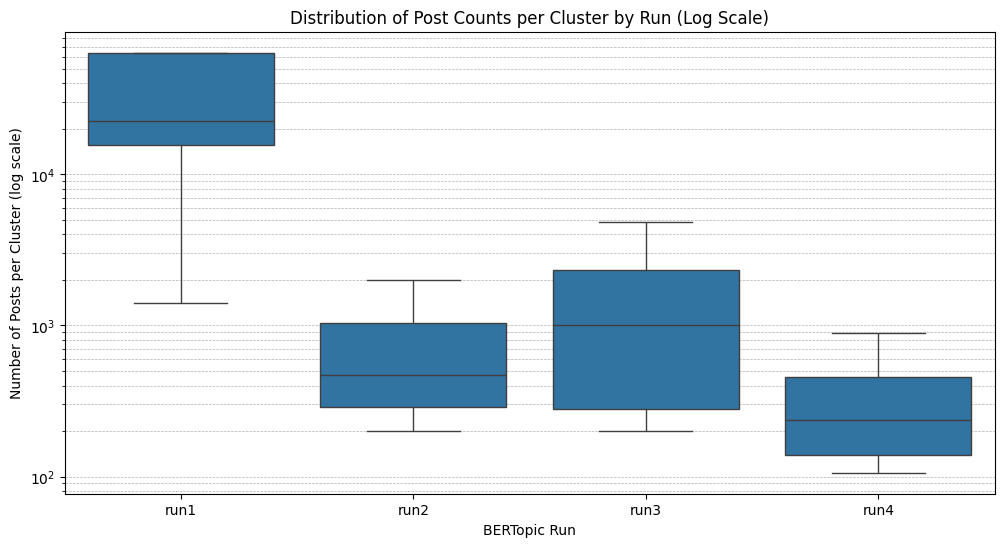

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Load cluster size data
df = pd.read_csv("/Users/tobiasmichelsen/Bachelor_Project/DS_BachelorProject_PH/Visualizations/cluster_sizes_per_run.csv")

# Convert Cluster ID to string to ensure sorting is categorical
df["Cluster ID"] = df["Cluster ID"].astype(str)

# Set up the plot
plt.figure(figsize=(12, 6))
sns.boxplot(x="Run", y="Post Count", data=df, showfliers=False)



# Add log scale
plt.yscale("log")

plt.title("Distribution of Post Counts per Cluster by Run (Log Scale)")
plt.ylabel("Number of Posts per Cluster (log scale)")
plt.xlabel("BERTopic Run")
plt.grid(True, which="both", axis="y", linestyle="--", linewidth=0.5)

# Save the figure
output_path = Path("/Users/tobiasmichelsen/Bachelor_Project/DS_BachelorProject_PH/Visualizations/cluster_size_distribution_per_run_log.png")
plt.savefig(output_path, bbox_inches='tight', dpi=300)
print(f"Saved: {output_path}")


In [12]:
## ANNOTATION VISUALISATIONS


import pandas as pd
import json
from pathlib import Path

# Configuration
BASE_PATH = "/Users/tobiasmichelsen/Bachelor_Project/DS_BachelorProject_PH"
ANNOTATION_DIR = Path(BASE_PATH) / "data/processed/annotated/Sampled_BERT_Runs"

RUNS = ["run1", "run2", "run3", "run4"]
summary = []

for run in RUNS:
    file_path = ANNOTATION_DIR / f"cluster_level_annotation_{run}.json"
    with open(file_path, "r", encoding="utf-8") as f:
        annotations = pd.DataFrame(json.load(f))

    total = len(annotations)
    removed = (annotations["annotated_label"].str.lower() != "yes").sum()
    retained = total - removed
    pct_removed = round(removed / total * 100, 1)

    summary.append({
        "Run": run.capitalize(),
        "Total Clusters": total,
        "Clusters Removed": removed,
        "Clusters Retained": retained,
        "% Removed": pct_removed
    })

# Create DataFrame
df = pd.DataFrame(summary)
print("\n=== Cluster Removal Summary ===")
print(df)

# Optional: Save to CSV
df.to_csv(f"{BASE_PATH}/Visualizations/cluster_annotation_removal_summary.csv", index=False)



=== Cluster Removal Summary ===
    Run  Total Clusters  Clusters Removed  Clusters Retained  % Removed
0  Run1               4                 3                  1       75.0
1  Run2             114                13                101       11.4
2  Run3              50                 6                 44       12.0
3  Run4              50                11                 39       22.0


'clusters_removed_per_run.png'

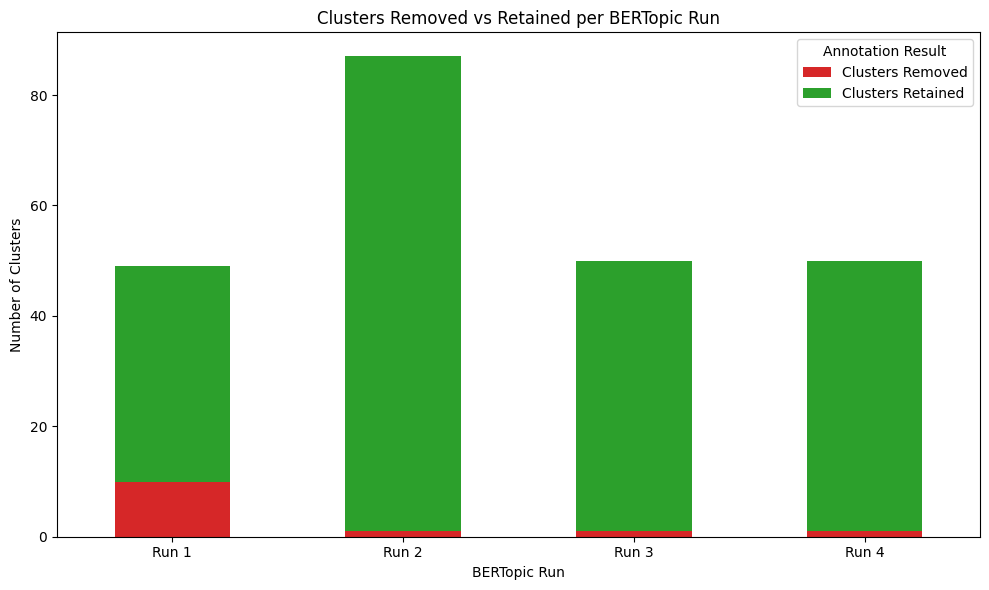

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Summary data from previous step
summary_data = {
    "Run": ["Run 1", "Run 2", "Run 3", "Run 4"],
    "Clusters Removed": [10, 1, 1, 1],
    "Clusters Retained": [39, 86, 49, 49]
}

df = pd.DataFrame(summary_data)
df.set_index("Run", inplace=True)

# Plot as stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
df.plot(kind="bar", stacked=True, ax=ax, color=["#d62728", "#2ca02c"])

plt.title("Clusters Removed vs Retained per BERTopic Run")
plt.ylabel("Number of Clusters")
plt.xlabel("BERTopic Run")
plt.xticks(rotation=0)
plt.legend(title="Annotation Result")
plt.tight_layout()

# Save the figure
output_path = Path("/Users/tobiasmichelsen/Bachelor_Project/DS_BachelorProject_PH/Visualizations/clusters_removed_per_run.png")
plt.savefig(output_path, dpi=300)
output_path.name


/var/folders/f3/z043mppd07z6npdj2ch2t1mm0000gn/T/ipykernel_6361/3842382350.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Run", y="% of Original Entries Retained", palette="Blues_d")


'share_of_original_entries_retained.png'

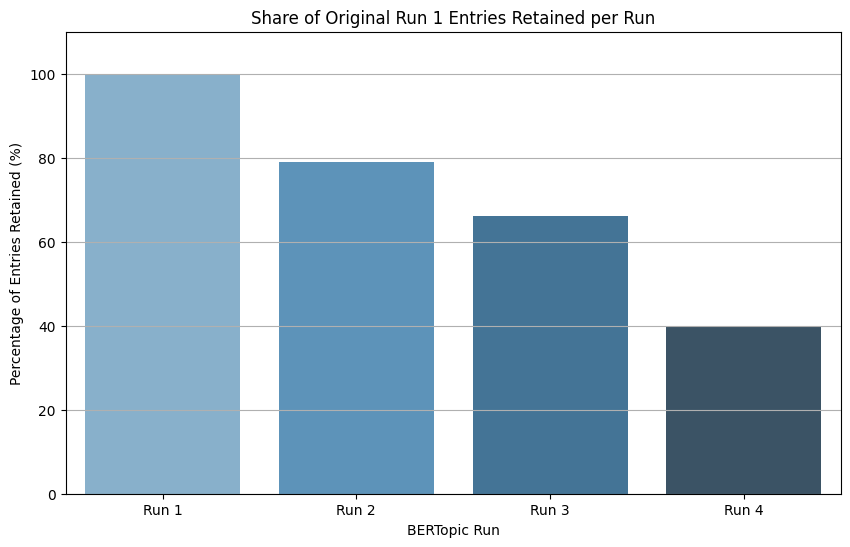

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Example share of entries retained from original dataset (Run 1)
summary_data = {
    "Run": ["Run 1", "Run 2", "Run 3", "Run 4"],
    "% of Original Entries Retained": [100.0, 79.1, 66.2, 39.8]  # Replace with actual values if needed
}

df = pd.DataFrame(summary_data)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="Run", y="% of Original Entries Retained", palette="Blues_d")

plt.title("Share of Original Run 1 Entries Retained per Run")
plt.ylabel("Percentage of Entries Retained (%)")
plt.ylim(0, 110)
plt.xlabel("BERTopic Run")
plt.grid(True, axis="y")

# Save figure
output_path = Path("/Users/tobiasmichelsen/Bachelor_Project/DS_BachelorProject_PH/Visualizations/share_of_original_entries_retained.png")
plt.savefig(output_path, dpi=300, bbox_inches='tight')
output_path.name


In [18]:
pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 168 kB 8.6 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/wordcloud_yes_vs_no_run1.png'

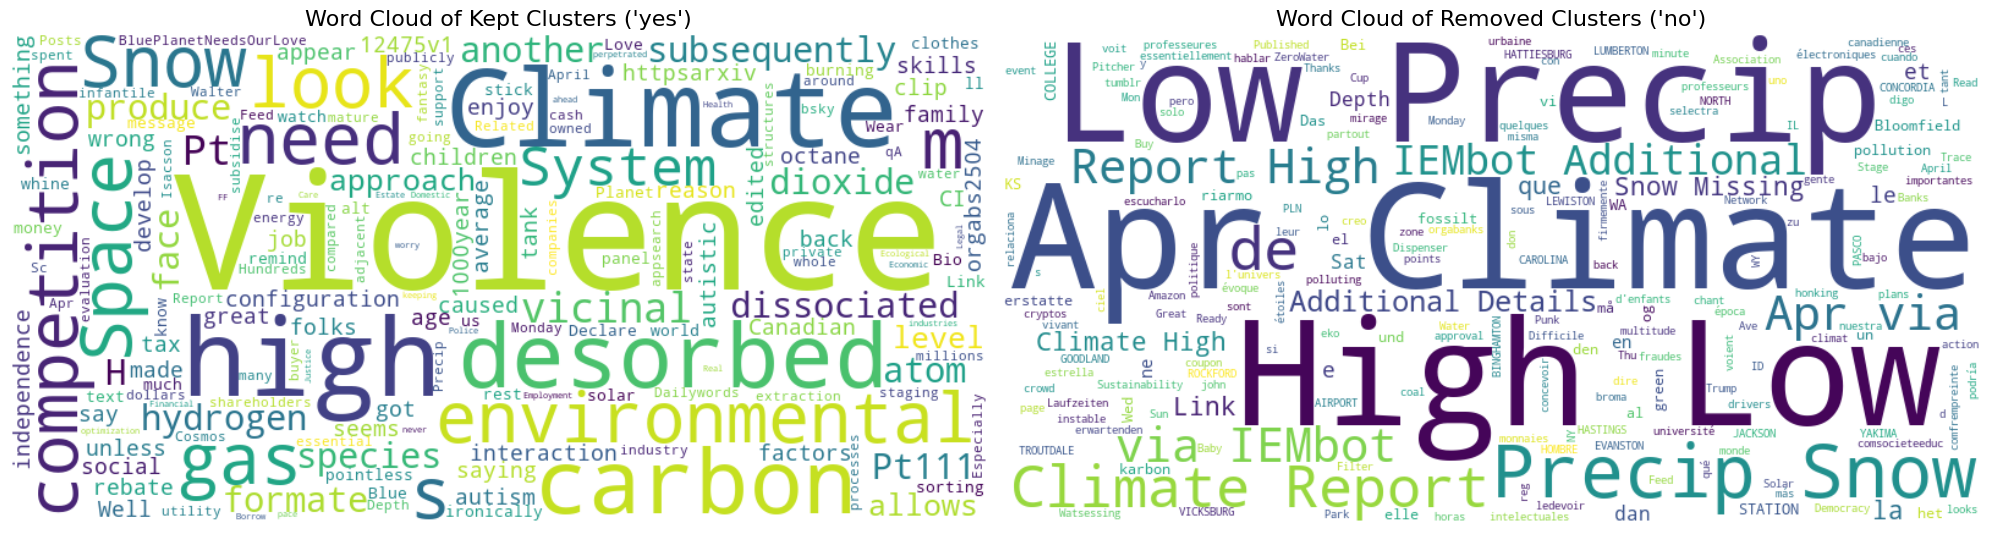

In [19]:
from wordcloud import WordCloud
import pandas as pd
import json
import matplotlib.pyplot as plt
from pathlib import Path

# Load annotations from Run 1 as an example
file_path = "/Users/tobiasmichelsen/Bachelor_Project/DS_BachelorProject_PH/data/processed/annotated/Sampled_BERT_Runs/cluster_level_annotation_run1.json"
with open(file_path, "r", encoding="utf-8") as f:
    annotations = pd.DataFrame(json.load(f))

# Filter clusters
yes_clusters = annotations[annotations["annotated_label"].str.lower() == "yes"]
no_clusters = annotations[annotations["annotated_label"].str.lower() != "yes"]

# Combine all sample texts for each group
yes_texts = " ".join([" ".join(cluster) for cluster in yes_clusters["sample_texts"]])
no_texts = " ".join([" ".join(cluster) for cluster in no_clusters["sample_texts"]])

# Generate word clouds
wordcloud_yes = WordCloud(width=800, height=400, background_color="white").generate(yes_texts)
wordcloud_no = WordCloud(width=800, height=400, background_color="white").generate(no_texts)

# Plot both word clouds side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(wordcloud_yes, interpolation="bilinear")
axes[0].set_title("Word Cloud of Kept Clusters ('yes')", fontsize=16)
axes[0].axis("off")

axes[1].imshow(wordcloud_no, interpolation="bilinear")
axes[1].set_title("Word Cloud of Removed Clusters ('no')", fontsize=16)
axes[1].axis("off")

# Save the figure
output_path = Path("/Users/tobiasmichelsen/Bachelor_Project/DS_BachelorProject_PH/data/processed/annotated/Sampled_BERT_Runs/cluster_level_annotation_run1.json")
plt.tight_layout()
plt.savefig(output_path, dpi=300)
output_path.name
